## 3. Structure discovery for the Lorenz-96 problem

In this notebook, we will show how we can estimate the conditional independence structure of a random variable $\mathsf{X} \in \mathbb{R}^{N_x}$ with density $\pi$ based on i.i.d. samples $\{\boldsymbol{x}^i\}, \; i = 1, \ldots, N_e$ from $\pi$.

We ar

References: 

[1] Lorenz, E.N., 1996, September. Predictability: A problem partly solved. In Proc. Seminar on predictability (Vol. 1, No. 1).

[2] Baptista, R., Zahm, O., & Marzouk, Y. (2020). An adaptive transport framework for joint and conditional density estimation. arXiv preprint arXiv:2009.10303.

[3] Baptista, R., Marzouk, Y., Morrison, R.E. and Zahm, O., 2021. Learning non-Gaussian graphical models via Hessian scores and triangular transport. arXiv preprint arXiv:2101.03093.


o generate i.i.d. samples from the system’s invariant (long-time) distribution, we sampleninitialconditions from a multivariate standard Gaussian distribution.  For each sample, we run the ODEin equation(SM.25)forT=  40,000steps using the Runge-Kutta method with a time-step of∆t= 0.01. The samples of the state at the final time are then i.i.d. samples from the push-forwarddistribution of the standard Gaussian through the nonlinear forward dynamics forTstep

In [1]:
using Revise
using LinearAlgebra
using TransportBasedInference
using Statistics
using Distributions
using OrdinaryDiffEq
using ProgressMeter

Load some packages to make nice figures

In [15]:
using Plots
default(fontfamily = "Computer Modern",
        tickfont = font("Computer Modern", 9), 
        titlefont = font("Computer Modern", 14), 
        guidefont = font("Computer Modern", 12),
        legendfont = font("Computer Modern", 10),
        grid = false)

using LaTeXStrings

The Lorenz-96 model [1] is a famous problem used in data assimilation and weather prediction. It was derived from first principles as a one-dimensional model for the response of the mid-latitude atmosphere to forcing input. For certain forcing input, it can exhibit a chaotic behavior: sensitivity to initial conditions, strong mixing. In this notebook, we consider the fifteen-dimensional version of the Lorenz-96 model.  The state $\boldsymbol{x} = (x_1, \ldots, x_{15})$ at time $t$ is governed by the following set of ordinary differential equations:  

\begin{equation}
    \frac{\mathrm{d}x_i}{\mathrm{d}t} = (x_{i+1} - x_{i-2}) x_{i-1} -x_i + F,
\end{equation}
where it is assumed that $x_{-1} = x_{n − 1} , x_0 = x_{n}$ and $x_{n+1} = x_1$, setting the forcing input $F=8.0$ leads to chaos.

We integrate the Lorenz-96 problem with our favorite ODE library: OrdinaryDiffEq.jl.

In [16]:
function lorenz96!(du,u,p,t)
    F = 8.0
    n = size(u,1)
    du[1] = (u[2]-u[end-1])*u[end] - u[1] + F
    du[2] = (u[3]-u[end])*u[1] - u[2] + F
    du[end] = (u[1] - u[end-2])*u[end-1] - u[end] + F

    @inbounds for i=3:n-1
        du[i] = (u[i+1] - u[i-2])*u[i-1] - u[i] + F
    end
    return du
end

lorenz96! (generic function with 1 method)

In [17]:
# Define the distribution for initial condition
Nx = 20
# Number of runs
Ne = 500
πx0 = MvNormal(zeros(Nx), ones(Nx))
# Zero vector of the size of the state
x0 = rand(πx0)

# Time stepp
tspan = (0.0, 500.0)
prob = ODEProblem(lorenz96!,x0, tspan)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 500.0)
u0: 20-element Vector{Float64}:
 -1.0840271519190747
  1.0540278721956875
 -0.7575185112805989
 -0.19505338339892223
  0.040948986147053466
  1.428932974579665
 -0.23243837489527397
 -0.5055295068021128
 -1.6738938074454668
  0.46277122031796764
  1.5882228409928076
  1.8655697812623435
  0.5414060062881485
  1.0154317417580438
 -0.5183466876405405
  1.1256431407369998
 -0.2606491090130804
 -0.28011355486749895
 -0.882994278136486
 -0.9040250626828792

Create cache to store the different final solutions

In [18]:
X = zeros(Nx, Ne);

Solve Lorenz-96 model for the different initial conditions and store the solutions as the columns of `X`

In [19]:
@inbounds for i=1:Ne
    prob = remake(prob; u0 = rand(πx0))
    sol = solve(prob, Tsit5(), dt = 0.01, adaptive = false, dense = false, saveat = tspan[end], save_start = false)
    X[:,i] = deepcopy(sol.u[1])
end

We can use the adaptive transport map procedure to estimate the underlying distribution for the state $\mathsf{X}$.

In [20]:
m = 60
S = HermiteMap(m, X; diag = true);

In [21]:
optimize(S, X, "kfold"; withqr = true, verbose = false, hessprecond = true)

LoadError: DimensionMismatch("array could not be broadcast to match destination")

In [9]:
plot(S)
# savefig("Lorenz96_structure.pdf")

LoadError: ArgumentError: range(0.0, stop=1.0, length=1): endpoints differ

Baptista et al.[3] showed that the conditional independence properties of a random variable $\mathsf{X} \in \mathbb{R}^n$ with density $\pi$ are specified by the *Hessian score matrix* $\boldsymbol{\Omega} \in \mathbb{R}^{n \times n}$ defined as:

\begin{equation}
\Omega_{i,j} = \mathrm{E}_{\pi} \left[ |\partial_i\partial_j \log \pi(\boldsymbol{x})|^2  \right] = \int |\partial_i\partial_j \log \pi(\boldsymbol{x})|^2 \pi(\boldsymbol{x}) \; \mathrm{d}\boldsymbol{x}.
\end{equation}

The pullback density $\boldsymbol{S}^{\sharp} \rho$ can be used to approximate the true density $\pi$, where $\rho$ denotes the standard Gaussian distribution of $\mathbb{R}^n$. Thus, the score matrix is estimated by [3]: 
\begin{equation}
\hat{\Omega}_{i,j} = \mathrm{E}_{\pi} \left[ |\partial_i\partial_j \log \boldsymbol{S}^{\sharp} \rho|^2  \right]
\end{equation}

In practice, we use a sampled-based approximation of $\hat{\boldsymbol{\Omega}}$ using samples $\{\boldsymbol{x}^k\}, \; k=1,\ldots, N_e$ of $\pi$ [3]:


\begin{equation}
\hat{\Omega}_{i,j} \approx \sum_{k=1}^{N_e}|\partial_i\partial_j \log \boldsymbol{S}^{\sharp}\rho(\boldsymbol{x}^k )|^2
\end{equation}

The function `hess_x_log_pdf!` computes in-place the Hessian of the log pdf of the pullback density $\boldsymbol{S}^{\sharp} \rho$. You can also use `hess_x_log_pdf`.

In [10]:
Ωhat = zeros(Nx, Nx)
cache = zeros(1, Nx, Nx)
@showprogress for i=1:Ne
    hess_x_log_pdf!(cache, S, X[:,i:i])
    Ωhat .+= copy(cache[1,:,:]).^2
end
rmul!(Ωhat, 1/Ne)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:20


20×20 Matrix{Float64}:
 83583.5      0.0      0.0      0.0  …      0.0      0.0      0.0      0.0
     0.0  83583.5      0.0      0.0         0.0      0.0      0.0      0.0
     0.0      0.0  83583.5      0.0         0.0      0.0      0.0      0.0
     0.0      0.0      0.0  83583.5         0.0      0.0      0.0      0.0
     0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
     0.0      0.0      0.0      0.0  …      0.0      0.0      0.0      0.0
     0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
     0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
     0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
     0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
     0.0      0.0      0.0      0.0  …      0.0      0.0      0.0      0.0
     0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
     0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
  

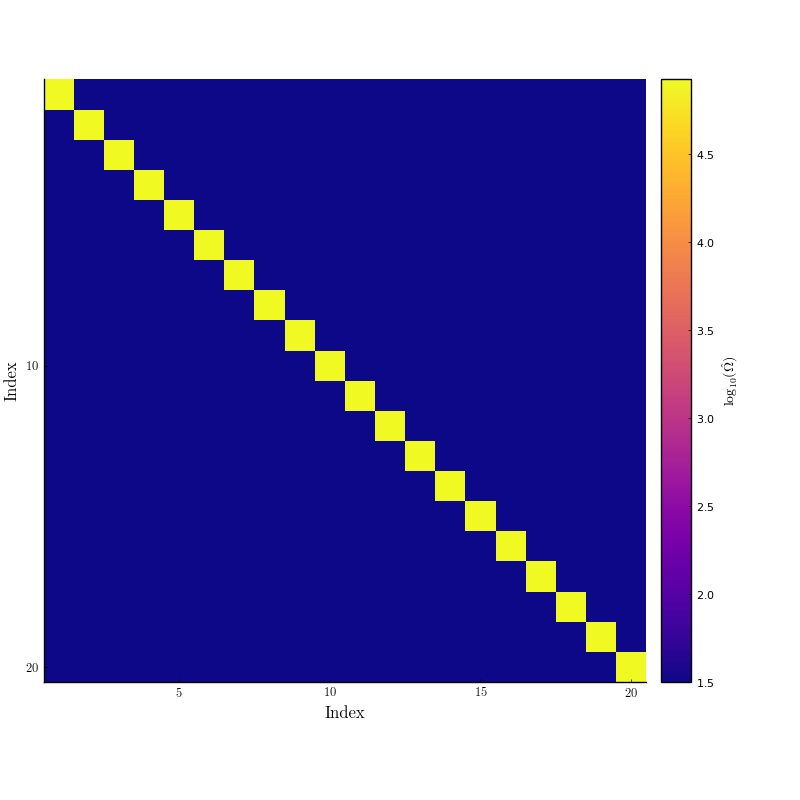

In [11]:
plt = plot(size = (800, 800))

heatmap!(plt,log10.(Ωhat), ratio = 1, yflip = true, 
        colorbar = true, color = :plasma, clim = (1.5, Inf), colorbar_title = L"\log_{10}(\hat{\Omega})",
        xlabel = "Index", ylabel = "Index", background_color_inside = palette(:plasma)[1], 
        yticks = (reverse(collect(0:10:Nx))))
plt